### outLine
Understand the problem and the data
Data cleaning and formatting (this was mostly done for us)
Exploratory Data Analysis
Baseline model
Improved model
Model interpretation (just a little)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
app_train = pd.read_csv("../4th_week/data/application_train.csv")
app_test = pd.read_csv("../4th_week/data/application_test.csv")
print(" 데이터:\n{}:".format(app_train.head()))

 데이터:
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   


### supervised and classification task

0이 상환한 경우이고 1이 상환하지못한 경우이다 우리가 발견해야하는건 1인지 여부
Class Imbalance Problem ?
전체 데이터에서 양성의 수가 음성의 수에 비해서 현저히 적은경우
다양한 분야에서 흔히 발견되는 문제이다, Fraud 탐지, 이상치 탐지, 의학진단, 기름유출 탐지, 얼굴인식

### 결측치를 어떻게 처리할것인가?
결측비율이 일정한 값 이상(예를 들면 70프로)이면 해당 컬럼을 삭제 또는 중위값으로 대체할 것인가

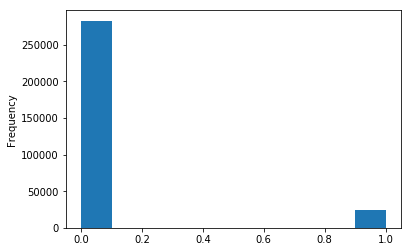

In [3]:
app_train['TARGET'].astype(int).plot.hist()

In [4]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [5]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### 범주형 데이터를 인코딩하는 방법
라벨로 인코딩하는 방법은 새로운 컬럼을 생성하지않고 값을 단순히 숫자로 치환하는 방법

테스트데이터에는 없고 훈련 데이터에는 있는 값이 경우 인코딩이 다르게 될 수 있다
따라서 두개 데이터를 묶어서 인코딩을 진행해야 한다.

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [7]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [8]:
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join='inner', axis=1)
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [9]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

### 이상치를 어떻게 처리할것인가?
보통의 값들로 대체하거나 아니면 nan 값으로 대체해서 이상치가 아닌 값들로만 비교를 하는 방법이 있다

In [10]:
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [11]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [12]:
correlations = app_train.corr()['TARGET'].sort_values()

In [13]:
correlations.head(15)

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED                          -0.044932
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
Name: TARGET, dtype: float64

In [14]:
correlations.tail(15)

DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

### 나이와 상환의 관계
나이를 더 먹을수록 더 잘 상환한다...
5년단위로 연령대를 나누어서 살펴보면 젋은 20~35세 그룹은 미상환율이 10%를 넘어서지만 65~70세는 미상환율이 5%도 못미친다

In [15]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

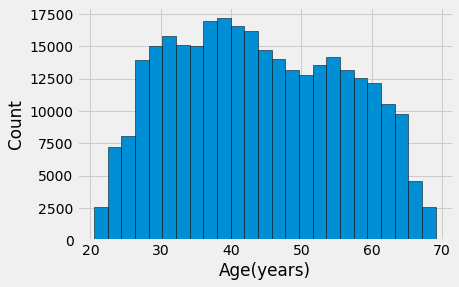

In [16]:
plt.style.use('fivethirtyeight')
plt.hist(app_train['DAYS_BIRTH']/365, edgecolor='k', bins=25)
plt.xlabel('Age(years)'); plt.ylabel('Count');

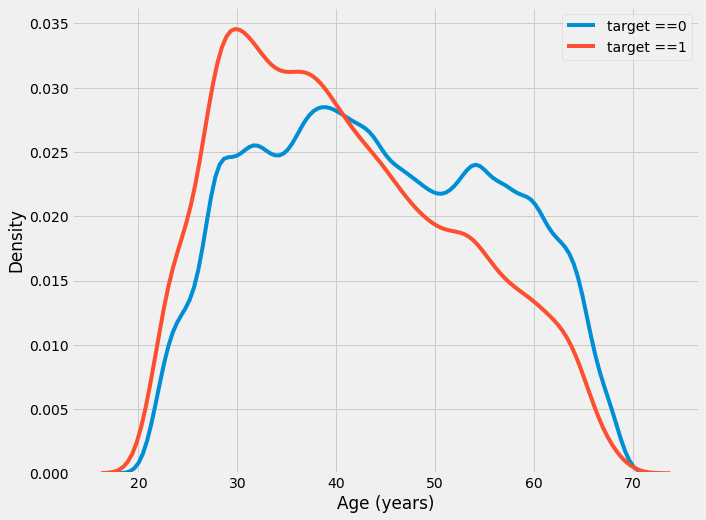

In [17]:
plt.figure(figsize= (10,8))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label= 'target ==0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label= 'target ==1')
plt.xlabel('Age (years)'); plt.ylabel('Density');

In [18]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins= np.linspace(20,70, num=11))
age_data.head(10)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [19]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


In [20]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5,1,'Correlation Heatamp')

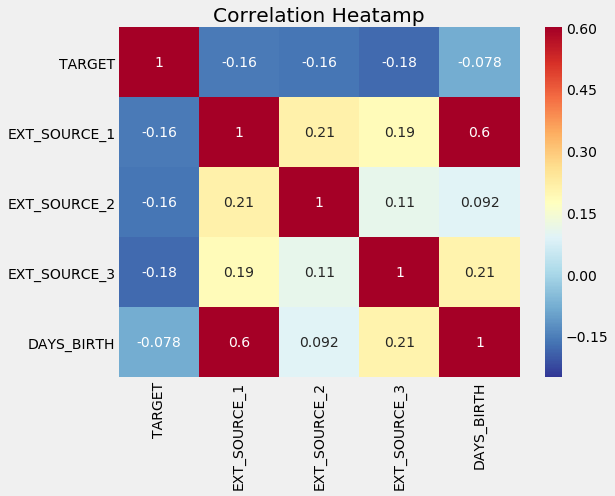

In [21]:
plt.figure(figsize= (8,6))

sns.heatmap(ext_data_corrs, cmap= plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatamp')

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


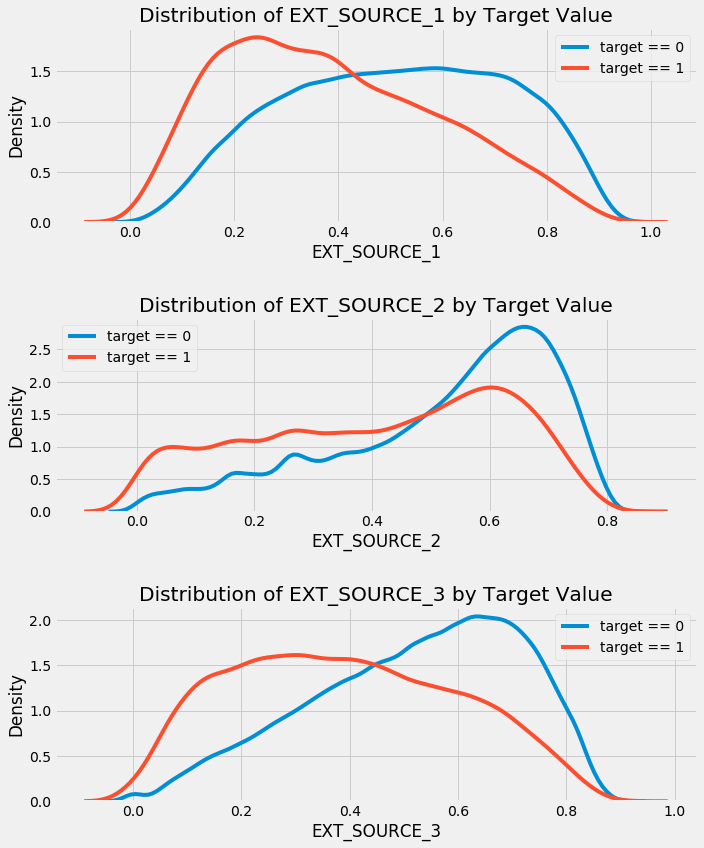

In [22]:
plt.figure(figsize= (10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i+1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label= 'target == 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label= 'target == 1')
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad= 2.5)
    

### polynomial Features
	http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
	https://pypi.org/project/patsy/

In [23]:
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

poly_target = poly_features['TARGET']
poly_featrues = poly_features.drop(columns= ['TARGET'])

poly_features = imputer.fit_transform(poly_featrues)
poly_features_test = imputer.fit_transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=3)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [24]:
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)


Polynomial Features shape:  (307511, 35)


In [25]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [26]:
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['TARGET'] = poly_target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [27]:
poly_features_test = pd.DataFrame(poly_features_test, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how= 'left')

poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how= 'left')

app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join='inner', axis=1)

print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)


Training data with polynomial features shape:  (307511, 274)
Testing data with polynomial features shape:   (48744, 274)


### 새로운 특성 추가해보기
CREDIT_INCOME_PERCENT,
ANNUITY_INCOME_PERCENT,
CREDIT_TERM,
DAYS_EMPLOYED_PERCENT

In [28]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [29]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

Series([], dtype: float64)

In [30]:
from sklearn.preprocessing import MinMaxScaler, Imputer

if 'TARGET' in app_train:
    train = app_train.drop(columns= ['TARGET'])
else :
    train = app_train.copy()
    
features = list(train.columns)

test = app_test.copy()
imputer = Imputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0,1))
imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


In [31]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C= 0.0001)
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [32]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [33]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred
submit.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SK_ID_CURR,TARGET
0,100001,0.087895
1,100005,0.163376
2,100013,0.110105
3,100028,0.076499
4,100038,0.155235


In [34]:
submit.to_csv('log_reg_baseline.csv', index=False)


In [41]:
## Good_fun_with_LigthGBM olivier

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [46]:
def build_model_input():
    buro_bal = pd.read_csv('../4th_week/data/bureau_balance.csv')
    print('Buro bal shape : ', buro_bal.shape)
    # buro_bal.head()

    print('transform to dummies')
    buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)
    # buro_bal.head()

    print('Counting buros')
    # buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
    buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
    # buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])
    buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])

    print('averaging buro bal')
    # avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()
    avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()

    avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
    del buro_bal
    gc.collect()
    # avg_buro_bal.head()

    

    print('Read Bureau')
    buro = pd.read_csv('../4th_week/data/bureau.csv')

    print('Go to dummies')
    buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
    buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
    buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')
    # buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')

    buro_full = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)
    # buro_full = pd.concat([buro, buro_credit_active_dum,,,], axis=1)
    # buro_full.columns = ['buro_' + f_ for f_ in buro_full.columns]

    del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
    gc.collect()

    print('Merge with buro avg')
    buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))
    # buro_full = buro_full.merge(right=avg_buro_Bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))

    print('Counting buro per SK_ID_CURR')
    nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
    # nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
    buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])
    # buro_full['SK_UD_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])

    print('Averaging bureau')
    avg_buro = buro_full.groupby('SK_ID_CURR').mean()
    # avg_buro = buro_full.groupby('SK_ID_CURR').mean()
    # print(avg_buro.head())

    del buro, buro_full
    gc.collect()

    print('Read prev')
    prev = pd.read_csv('../4th_week/data/previous_application.csv')

    prev_cat_features = [
        f_ for f_ in prev.columns if prev[f_].dtype == 'object'
    #     f_ for f_ in prev.columns if prev[f_].dtype == 'object'
    ]

    print('Go to dummies')
    prev_dum = pd.DataFrame()
    for f_ in prev_cat_features:
        prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)
    #     prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)

    prev = pd.concat([prev, prev_dum], axis=1)
    # prev = pd.concat([prev, prev_dum], axis=1)

    del prev_dum
    gc.collect()

    print('Counting number of Prevs')
    nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    # nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])
    # prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])

    print('Averaging prev')
    avg_prev = prev.groupby('SK_ID_CURR').mean()
    # avg_prev = prev.groupby('SK_ID_CURR').mean()
    # print(avg_prev.head())
    del prev
    gc.collect()

    print('Reading POS_CASH')
    pos = pd.read_csv('../4th_week/data/POS_CASH_balance.csv')

    print('Go to dummies')
    pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)
    # pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)

    print('Compute nb of prevs per curr')
    nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    # nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    # nb_prevs.head()

    print('Go to averages')
    avg_pos = pos.groupby('SK_ID_CURR').mean()

    del pos, nb_prevs
    gc.collect()

    print('Reading CC balance')
    cc_bal = pd.read_csv('../4th_week/data/credit_card_balance.csv')

    print('Go to dummies')
    cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')], axis=1)

    nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

    print('Compute average')
    avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
    avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]

    del cc_bal, nb_prevs
    gc.collect()

    print('Reading Installments')
    inst = pd.read_csv('../4th_week/data/installments_payments.csv')
    nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

    avg_inst = inst.groupby('SK_ID_CURR').mean()
    avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]

    print('Read data and test')
#     data = pd.read_csv('../4th_week/data/application_train.csv')
#     test = pd.read_csv('../4th_week/data/application_test.csv')
    data = app_train_domain
    test = app_test_domain
    print('Shapes : ', data.shape, test.shape)

    y = data['TARGET']
    del data['TARGET']

    categorical_feats = [
        f for f in data.columns if data[f].dtype == 'object'
    ]
    categorical_feats
    for f_ in categorical_feats:
        data[f_], indexer = pd.factorize(data[f_])
    #     data[f_], indexer = pd.factorize(data[f_])
        test[f_] = indexer.get_indexer(test[f_])
    #     test[f_] = indexer.get_indexer(test[f_])

    data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

    data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

    data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')

    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

    del avg_buro, avg_prev
    gc.collect()

    return data, test, y

In [43]:
def train_model(data_, test_, y_, folds_):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    feats = [f for f in data_.columns if f not in ['SK_ID_CURR']]
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            subsample_freq=1,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            random_state=0,
            silent=-1,
            verbose=-1, )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=200  #100
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['TARGET'] = sub_preds

    return oof_preds, test_[['SK_ID_CURR', 'TARGET']], feature_importance_df

In [44]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances_02.png')

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
Read prev
Go to dummies
Counting number of Prevs
Averaging prev
Reading POS_CASH
Go to dummies
Compute nb of prevs per curr
Go to averages
Reading CC balance
Go to dummies
Compute average
Reading Installments
Read data and test
Shapes :  (307511, 244) (48744, 243)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.751853	valid_1's auc: 0.740576
[200]	training's auc: 0.778916	valid_1's auc: 0.762398
[300]	training's auc: 0.796908	valid_1's auc: 0.774803
[400]	training's auc: 0.808606	valid_1's auc: 0.780563
[500]	training's auc: 0.817656	valid_1's auc: 0.783787
[600]	training's auc: 0.825233	valid_1's auc: 0.785485
[700]	training's auc: 0.832415	valid_1's auc: 0.786902
[800]	training's auc: 0.838833	valid_1's auc: 0.787803
[900]	training's auc: 0.844843	valid_1's auc: 0.78846

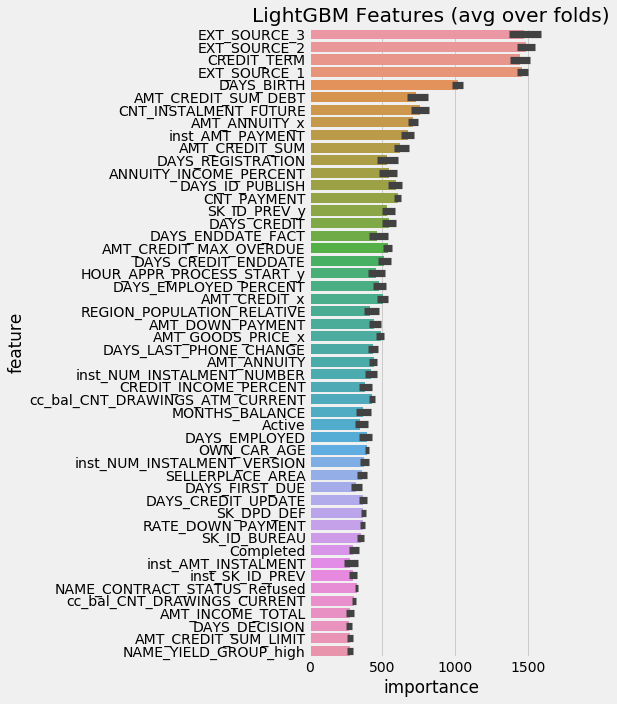

In [47]:
if __name__ == '__main__':
    gc.enable()
    # Build model inputs
    data, test, y = build_model_input()
    # Create Folds
    folds = KFold(n_splits=5, shuffle=True, random_state=546789)
    # Train model and get oof and test predictions
    oof_preds, test_preds, importances = train_model(data, test, y, folds)
    # Save test predictions
    test_preds.to_csv('submission_lightGBM_20180722.csv', index=False)
    # Display a few graphs
    folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(data)]
    display_importances(feature_importance_df_=importances)
#     display_roc_curve(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)
#     display_precision_recall(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)